# Notebook code copied from Quantopian's Pairs Trading Lecture

In [1]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS

np.random.seed(107)

import matplotlib.pyplot as plt

In [2]:
# Set default figure size
plt.rcParams['figure.figsize'] = (12, 6)  # Adjust the width and height as needed

# Enable gridlines
plt.rcParams['axes.grid'] = True

<AxesSubplot:>

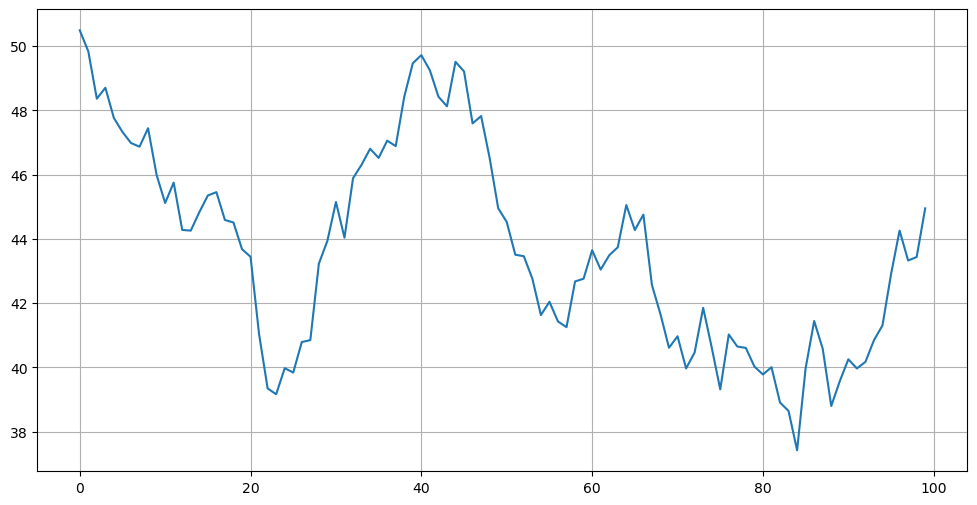

In [3]:
# Create a random walk called X
X_returns = np.random.normal(0, 1, 100)
X = pd.Series(np.cumsum(X_returns), name='X') + 50
X.plot()

<AxesSubplot:>

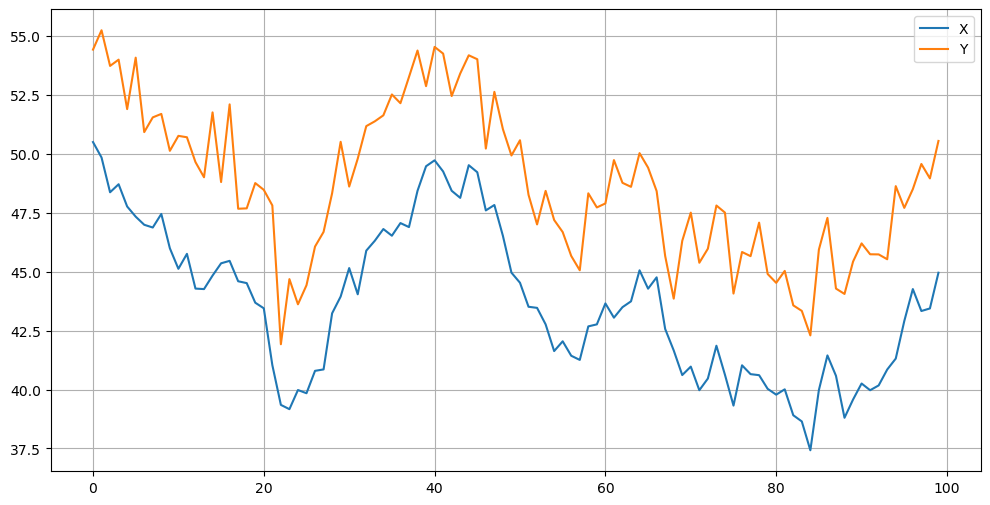

In [4]:
some_noise = np.random.normal(0, 1, 100)
Y = X + 5 + some_noise
Y.name = 'Y'
pd.concat([X, Y], axis=1).plot()

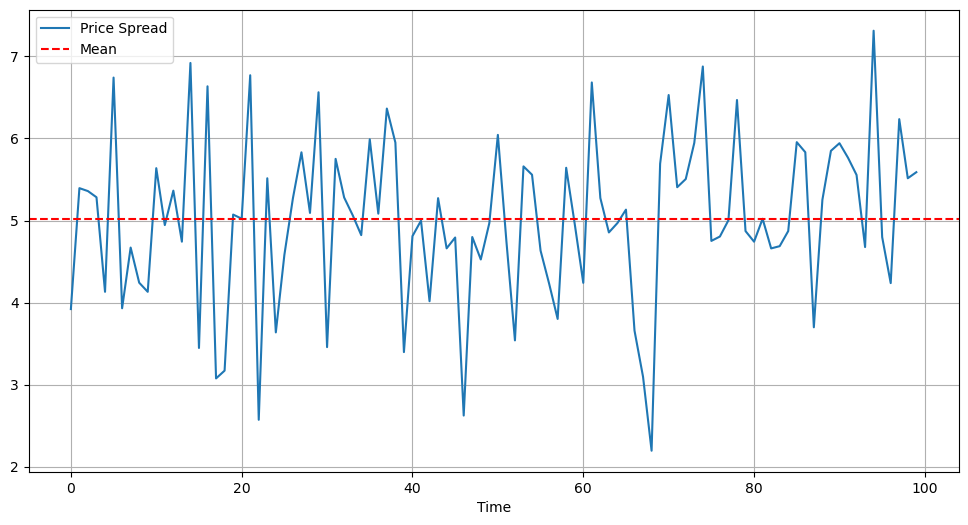

In [5]:
# Cointegration: if two timeseries are cointegrated, there is some linear combination of them that will vary around a mean.
(Y - X).plot()
plt.axhline((Y - X).mean(), color='red', linestyle='--')
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

In [6]:
# Test for cointegration
# Null: Not cointegrated
# Alternate: Cointegrated
score, pvalue, _ = coint(X, Y)
print(pvalue)

2.0503418653413122e-16


In [7]:
# Correlation is not Cointegration
# You can have one without the other
X.corr(Y)

0.9497090646385927

<AxesSubplot:>

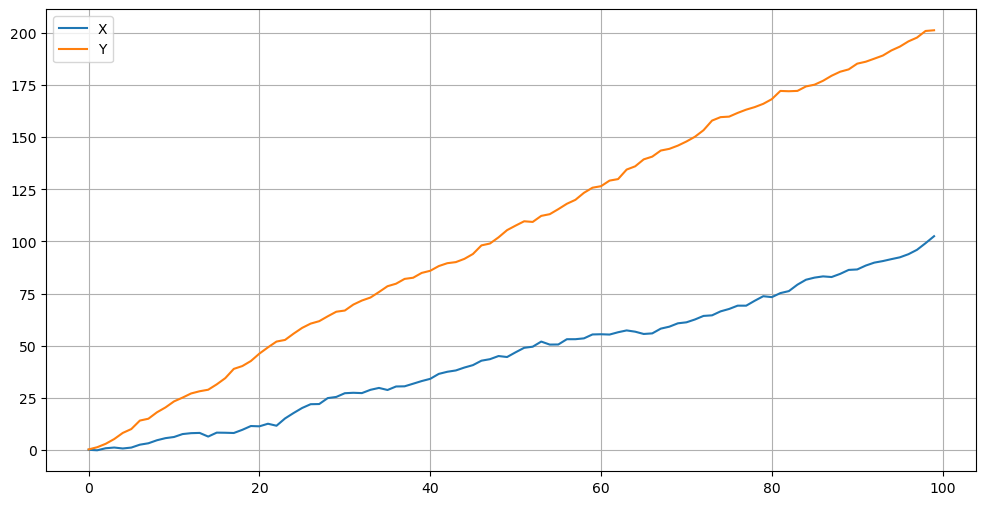

In [8]:
# Correlation without Cointegration
# A simple example is two series that just diverge
X_returns = np.random.normal(1, 1, 100)
Y_returns = np.random.normal(2, 1, 100)

X_diverging = pd.Series(np.cumsum(X_returns), name='X')
Y_diverging = pd.Series(np.cumsum(Y_returns), name='Y')

pd.concat([X_diverging, Y_diverging], axis=1).plot()

In [9]:
print("Correlation: " + str(X_diverging.corr(Y_diverging)))
score, pvalue, _ = coint(X_diverging, Y_diverging)
print("Cointegration test pvalue: " + str(pvalue))

Correlation: 0.9931343801275687
Cointegration test pvalue: 0.8815557674695222


(0.0, 40.0)

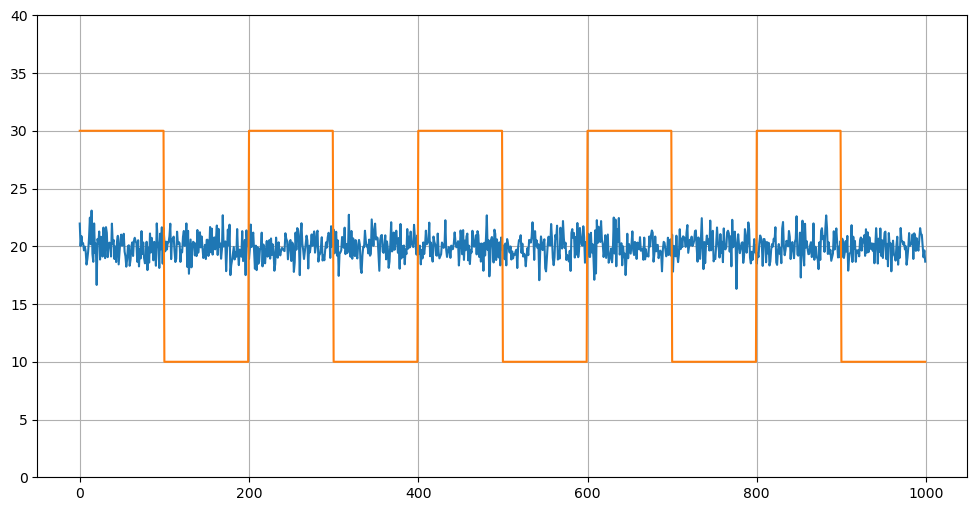

In [10]:
# Cointegration without Correlation
# A simple example is a normally distributed series and a square wave.
Y2 = pd.Series(np.random.normal(0, 1, 1000), name='Y2') + 20
Y3 = Y2.copy()
Y3[0:100] = 30
Y3[100:200] = 10
Y3[200:300] = 30
Y3[300:400] = 10
Y3[400:500] = 30
Y3[500:600] = 10
Y3[600:700] = 30
Y3[700:800] = 10
Y3[800:900] = 30
Y3[900:1000] = 10

Y2.plot()
Y3.plot()
plt.ylim([0, 40])

In [11]:
print("Correlation: " + str(Y2.corr(Y3)))
score, pvalue, _ = coint(Y2, Y3)
print("Cointegration test pvalue: " + str(pvalue))

Correlation: -0.041304069580916626
Cointegration test pvalue: 0.0


In [12]:
# The nice thing about going long or short the spread is that we are always sort of hedged

In [13]:
# Finding cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i + 1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [14]:
# Remember that multiple comparisons bias is a thing, and there could also be confounding variables

In [15]:
# get_pricing() is a Quantopian method that gets a df with prices...

In [16]:
# !pip install yfinance
import yfinance as yf

In [17]:
# symbol_list = ['ABG', 'ASTI', 'CSUN', 'DQ', 'FSLR', 'SPY']
symbol_list = ['ABG', 'XOM', 'CVX', 'KO', 'PEP', 'FSLR', 'SPY']

In [18]:
# Set the timeframe
start_date = '2014-01-01'
end_date = '2015-01-01'

# Initialize an empty DataFrame to store the closing prices
df = pd.DataFrame()

# Loop through each symbol and fetch historical data
for symbol in symbol_list:
    # Fetch historical data from Yahoo Finance
    data = yf.download(symbol, start=start_date, end=end_date)
    
    # Extract the 'Close' column and rename it with the symbol
    df[symbol] = data['Close']

# Display the resulting DataFrame
df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,ABG,XOM,CVX,KO,PEP,FSLR,SPY
Date,,,,,,,
2014-01-02,53.980000,99.750000,124.139999,40.660000,82.099998,57.439999,182.919998
2014-01-03,53.029999,99.510002,124.349998,40.459999,82.239998,56.740002,182.889999
2014-01-06,52.709999,99.660004,124.019997,40.270000,82.279999,51.259998,182.360001
2014-01-07,52.810001,101.070000,125.070000,40.389999,83.480003,52.490002,183.479996
2014-01-08,52.090000,100.739998,123.290001,39.939999,83.239998,51.680000,183.520004


[('ABG', 'SPY'), ('KO', 'PEP'), ('KO', 'SPY')]


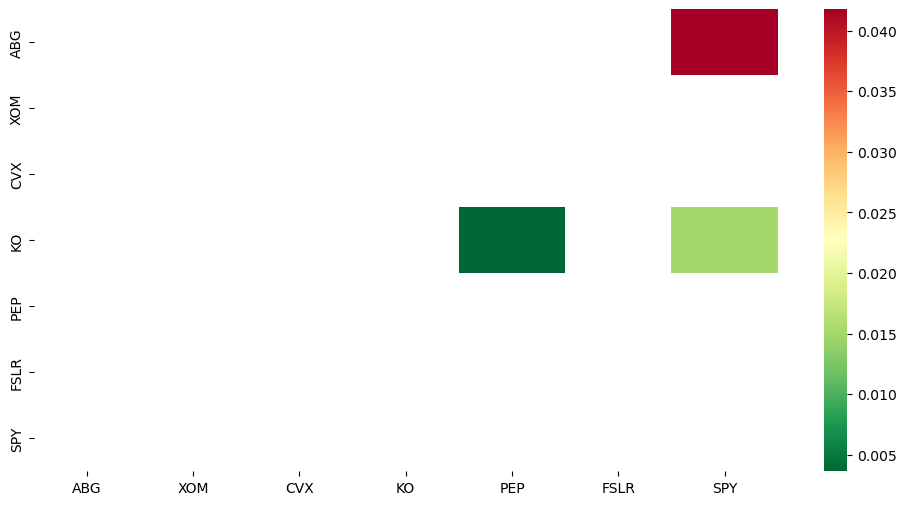

In [19]:
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
seaborn.heatmap(pvalues, xticklabels=symbol_list, yticklabels=symbol_list, cmap='RdYlGn_r', mask = (pvalues >= 0.05))
print(pairs)

In [20]:
# Let's just use Coca-Cola and Pepsi
S1 = df['KO']
S2 = df['PEP']

In [37]:
S1

Date
2014-01-02    40.660000
2014-01-03    40.459999
2014-01-06    40.270000
2014-01-07    40.389999
2014-01-08    39.939999
                ...    
2014-12-24    42.939999
2014-12-26    42.959999
2014-12-29    42.860001
2014-12-30    42.759998
2014-12-31    42.220001
Name: KO, Length: 252, dtype: float64

In [38]:
S1.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 252 entries, 2014-01-02 to 2014-12-31
Series name: KO
Non-Null Count  Dtype  
--------------  -----  
252 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


In [22]:
score, pvalue, _ = coint(S1, S2)
pvalue

0.003633072835927776

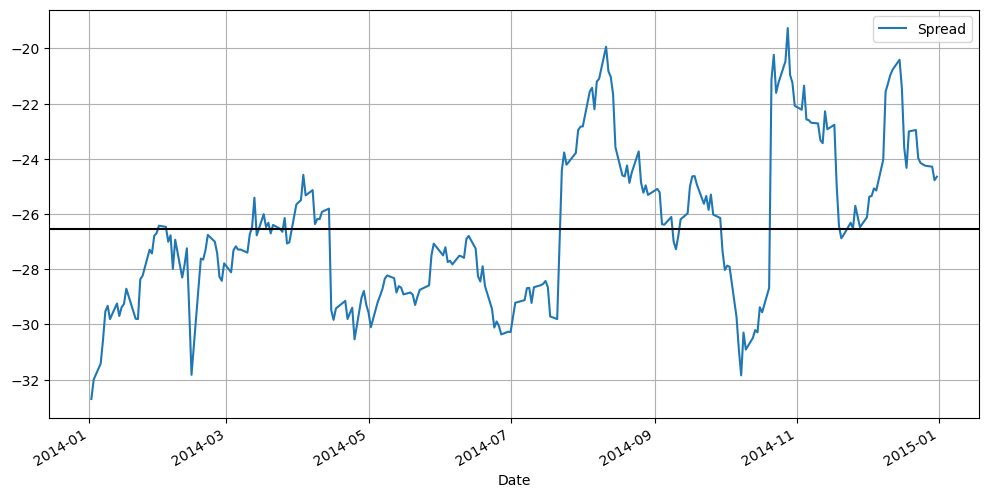

In [23]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['KO']
b = results.params['KO']

spread = S2 - b * S1
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread'])

In [24]:
b

2.8235308725039396

In [25]:
np.mean(S1)

40.841309426322816

In [26]:
np.mean(S2)

88.77813523913187

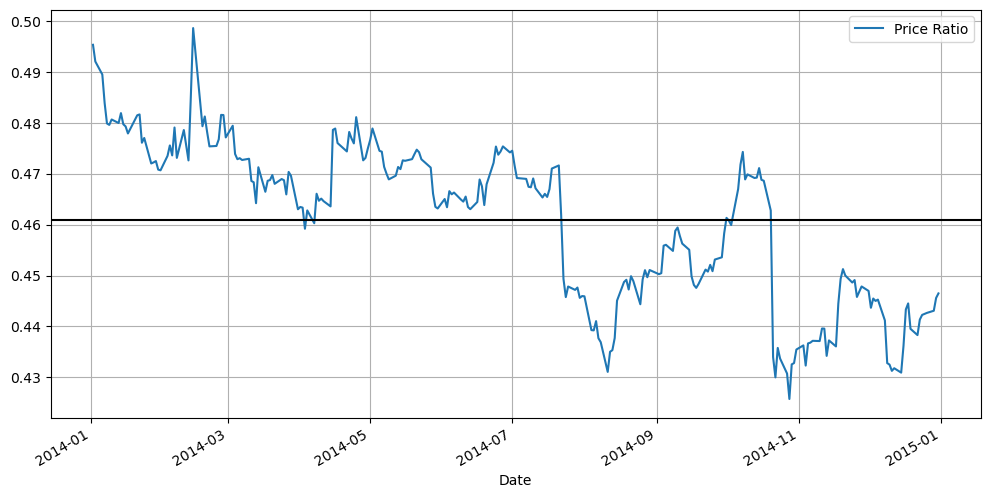

In [27]:
ratio = S1/S2
ratio.plot()
plt.axhline(ratio.mean(), color='black')
plt.legend(['Price Ratio'])

In [28]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

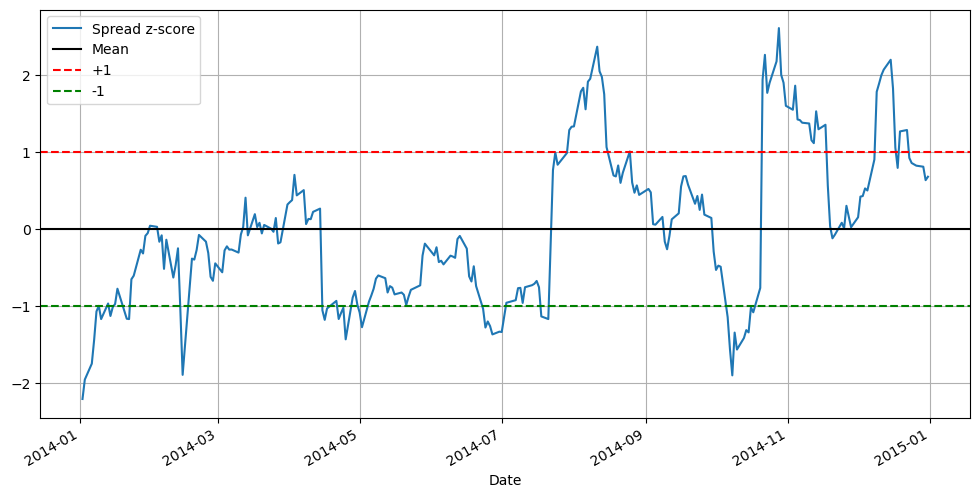

In [29]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])

In [30]:
# We have look-ahead bias, because beta is based on total info, which we shouldn't know if we're stepping through

In [31]:
# The lecture uses what seems to be an outdated rolling ols function, so I have to figure out how to use a different one
# I'm trying RollingOLS from statsmodels right now, not sure if I'm using it entirely correctly right now...

rolling_ols = RollingOLS(endog=S2, exog=S1, window=30)
rolling_results = rolling_ols.fit()

coefficients = rolling_results.params
coefficients

,KO
Date,
2014-01-02,NaN
2014-01-03,NaN
2014-01-06,NaN
2014-01-07,NaN
2014-01-08,NaN
...,...
2014-12-24,2.263714
2014-12-26,2.263193
2014-12-29,2.261676


Text(0, 0.5, 'Spread')

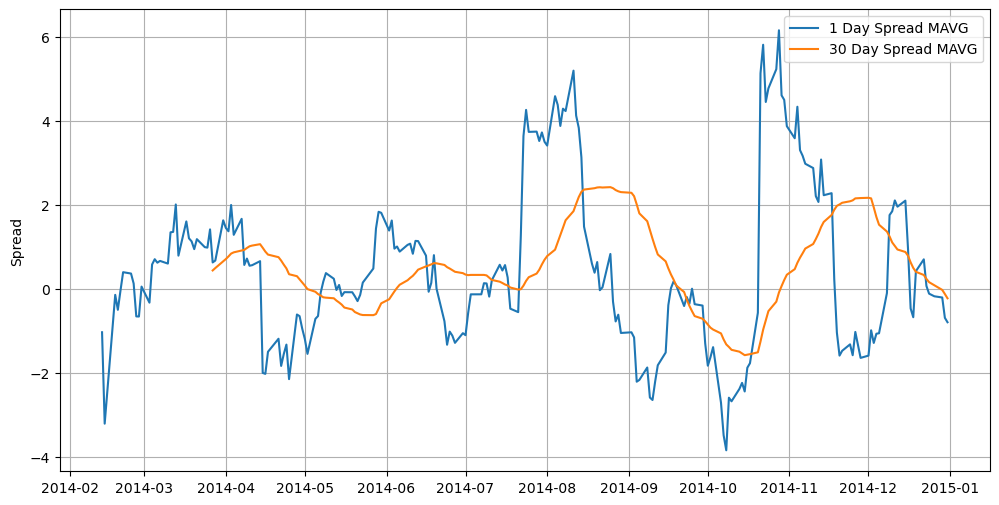

In [32]:
spread = S2 - coefficients['KO'] * S1
spread.name = 'spread'

spread_mavg1 = spread.rolling(window=1).mean()
spread_mavg1.name = 'spread 1d mavg'

spread_mavg30 = spread.rolling(window=30).mean()
spread_mavg30.name = 'spread 30d mavg'

plt.plot(spread_mavg1.index, spread_mavg1.values)
plt.plot(spread_mavg30.index, spread_mavg30.values)

plt.legend(['1 Day Spread MAVG', '30 Day Spread MAVG'])

plt.ylabel('Spread')

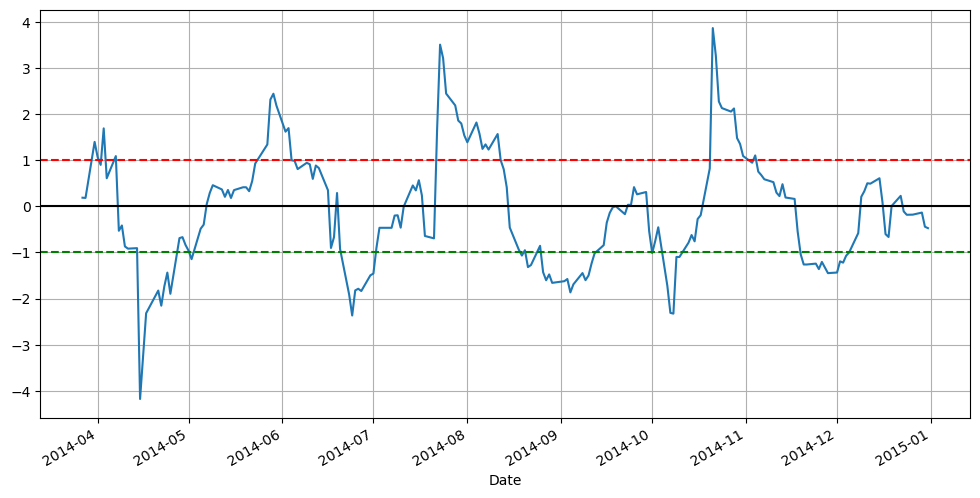

In [33]:
# Now do rolling std
std_30 = spread.rolling(window=30).std()
std_30.name = 'std 30d'

# Compute the z score for each day
# Basically the 1 mavg is like the spread itself, the 30 mavg is its mean. So we are standardizing
zscore_30_1 = (spread_mavg1 - spread_mavg30) / std_30
zscore_30_1.name = 'z-score'
zscore_30_1.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
# plt.axhline(2.0, color='orange', linestyle='--')
# plt.axhline(-2.0, color='purple', linestyle='--')

# The point is that this rolling, standardized spread looks different than the un-rolled standardized spread that we got earlier

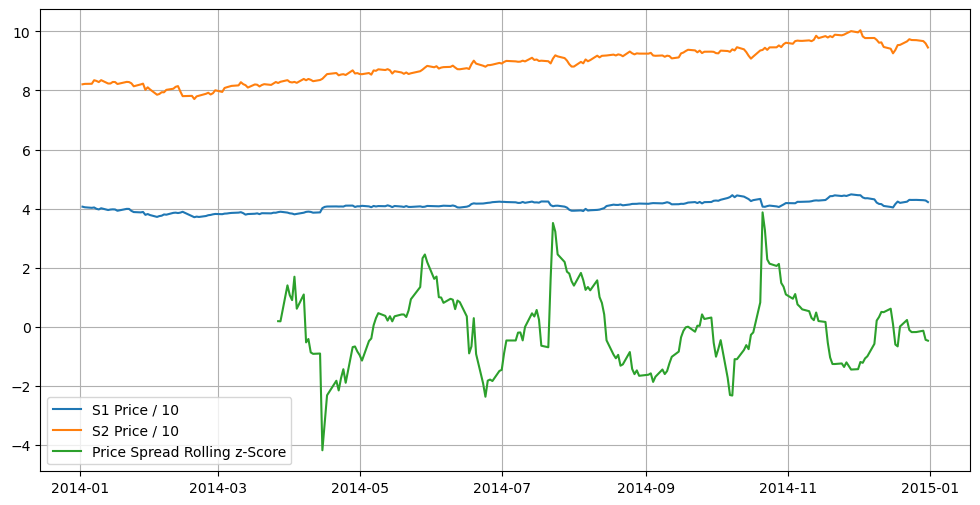

In [34]:
plt.plot(S1.index, S1.values / 10)
plt.plot(S2.index, S2.values / 10)
plt.plot(zscore_30_1.index, zscore_30_1.values)
plt.legend(['S1 Price / 10', 'S2 Price / 10', 'Price Spread Rolling z-Score'])

In [35]:
# The actual implementation will be more involved... maybe there is a site that contains old quantopian algos?

![Implementation Screenshot](./implementation_screenshot.png)